## Refine Endothelial cell annotations for large intestine - relabelling uncertain cells based on manual inspection/majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

### Import

In [6]:
#import data
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Endo_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

In [8]:
#import scanvi coordinates
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Endo_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

LV1       LV2       LV3       LV4  \
index                                                                      
AAAGCAAAGAGCTGGT-4918STDY7273964 -0.085672 -0.626934  0.046728  0.074449   
AACCATGTCCAGTAGT-4918STDY7273964  0.513567  0.433343 -0.037089  0.019089   
AACTGGTGTAGCTCCG-4918STDY7273964 -0.300526  0.388939  0.028503  0.080027   
AAGCCGCTCGTACGGC-4918STDY7273964  0.618780  0.884257 -0.000787  0.006789   
AAGGCAGGTAGCACGA-4918STDY7273964  0.853992  0.063295 -0.025488  0.018689   
...                                    ...       ...       ...       ...   
TTGACTTTCCTACAGA-GSM4546346       1.073934 -0.450200  0.058139  0.057115   
TTGCGTCTCCCAAGTA-GSM4546346       0.474677  0.881596 -0.020935 -0.024452   
TTTACTGCAAACCCAT-GSM4546346       0.264444 -0.572553  0.072592  0.047862   
TTTGGTTAGATCGATA-GSM4546346       1.022337  0.310472  0.003159  0.019706   
TTTGGTTAGATTACCC-GSM4546346       0.827731  1.007763 -0.019257 -0.004659   

                                       LV5       LV6       LV7       LV8  \
index                                                                      
AAAGCAAAGAGCTGGT-4918STDY7273964 -1.022110 -1.373578  0.941454  0.028259   
AACCATGTCCAGTAGT-4918STDY7273964  0.934302 -1.784075  0.443836  0.028841   
AACTGGTGTAGCTCCG-4918STDY7273964 -1.776161 -1.615989  0.842389  0.049374   
AAGCCGCTCGTACGGC-4918STDY7273964  0.465004  1.587941 -0.299724 -0.035661   
AAGGCAGGTAGCACGA-4918STDY7273964  0.183490  0.816863 -1.565917 -0.041497   
...                                    ...       ...       ...       ...   
TTGACTTTCCTACAGA-GSM4546346      -0.174826  0.893707 -0.347016 -0.048292   
TTGCGTCTCCCAAGTA-GSM4546346       0.321261 -1.975901  0.685044  0.044340   
TTTACTGCAAACCCAT-GSM4546346      -1.265912 -0.235569 -1.290525 -0.045115   
TTTGGTTAGATCGATA-GSM4546346      -0.207116  1.697081 -1.132632 -0.059267   
TTTGGTTAGATTACCC-GSM4546346       0.128517  2.049760 -0.856652 -0.058583   

                                       LV9      LV10      LV11      LV12  \
index                                                                      
AAAGCAAAGAGCTGGT-4918STDY7273964  0.043873  0.494943  0.061282 -0.080914   
AACCATGTCCAGTAGT-4918STDY7273964  0.035380  0.395802  0.085531 -0.146290   
AACTGGTGTAGCTCCG-4918STDY7273964  0.014130  0.143625 -0.000241 -0.076925   
AAGCCGCTCGTACGGC-4918STDY7273964  0.071659 -0.675425  0.029039 -0.019870   
AAGGCAGGTAGCACGA-4918STDY7273964  0.004903 -0.169736  0.015550 -0.048722   
...                                    ...       ...       ...       ...   
TTGACTTTCCTACAGA-GSM4546346       0.032940 -0.238452 -0.077263  0.022652   
TTGCGTCTCCCAAGTA-GSM4546346       0.006979  0.001526  0.008774 -0.127855   
TTTACTGCAAACCCAT-GSM4546346       0.022997  0.240387  0.025141 -0.030886   
TTTGGTTAGATCGATA-GSM4546346       0.023618 -0.201739 -0.012862 -0.005214   
TTTGGTTAGATTACCC-GSM4546346       0.017571  0.068027  0.024388 -0.035580   

                                      LV13      LV14      LV15      LV16  \
index                                                                      
AAAGCAAAGAGCTGGT-4918STDY7273964 -0.806504 -0.236679 -0.804982 -0.026352   
AACCATGTCCAGTAGT-4918STDY7273964 -1.410292 -0.069396 -0.603088  0.026918   
AACTGGTGTAGCTCCG-4918STDY7273964 -0.334051 -0.239699 -0.973325 -0.060877   
AAGCCGCTCGTACGGC-4918STDY7273964 -0.837068 -0.134919  0.120280  0.005912   
AAGGCAGGTAGCACGA-4918STDY7273964  0.295476 -0.718855  0.013665  0.005532   
...                                    ...       ...       ...       ...   
TTGACTTTCCTACAGA-GSM4546346       0.139978  0.811984 -0.652261 -0.008505   
TTGCGTCTCCCAAGTA-GSM4546346       0.688731 -0.111170 -0.326338 -0.050552   
TTTACTGCAAACCCAT-GSM4546346      -0.205228  0.316641 -0.747930 -0.071070   
TTTGGTTAGATCGATA-GSM4546346       0.189897  0.464526  0.464569 -0.007943   
TTTGGTTAGATTACCC-GSM4546346      -0.454928  0.902845  1.629695  0.008792   

                                      LV17      LV18      LV19      LV20  
index   

In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
#import metadata
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Endo_20230226.csv',index_col=0)

In [12]:
adata_meta

latent_cell_probability  \
index                                                       
AAAGCAAAGAGCTGGT-4918STDY7273964                 0.999677   
AACCATGTCCAGTAGT-4918STDY7273964                 0.999603   
AACTGGTGTAGCTCCG-4918STDY7273964                 0.999859   
AAGCCGCTCGTACGGC-4918STDY7273964                 0.999608   
AAGGCAGGTAGCACGA-4918STDY7273964                 0.999894   
...                                                   ...   
TTGACTTTCCTACAGA-GSM4546346                      0.999876   
TTGCGTCTCCCAAGTA-GSM4546346                      0.999782   
TTTACTGCAAACCCAT-GSM4546346                      0.999269   
TTTGGTTAGATCGATA-GSM4546346                      0.999885   
TTTGGTTAGATTACCC-GSM4546346                      0.999706   

                                  latent_RT_efficiency    cecilia22_predH  \
index                                                                       
AAAGCAAAGAGCTGGT-4918STDY7273964              1.289961  Endothelial cells   
AACCATGTCCAGTAGT-4918STDY7273964              1.141778  Endothelial cells   
AACTGGTGTAGCTCCG-4918STDY7273964              2.151045  Endothelial cells   
AAGCCGCTCGTACGGC-4918STDY7273964              1.534861  Endothelial cells   
AAGGCAGGTAGCACGA-4918STDY7273964              2.819811  Endothelial cells   
...                                                ...                ...   
TTGACTTTCCTACAGA-GSM4546346                   2.817957  Endothelial cells   
TTGCGTCTCCCAAGTA-GSM4546346                   2.121822  Endothelial cells   
TTTACTGCAAACCCAT-GSM4546346                   1.186025  Endothelial cells   
TTTGGTTAGATCGATA-GSM4546346                   2.633791  Endothelial cells   
TTTGGTTAGATTACCC-GSM4546346                   1.702504  Endothelial cells   

                                  cecilia22_predH_prob  \
index                                                    
AAAGCAAAGAGCTGGT-4918STDY7273964              1.000000   
AACCATGTCCAGTAGT-4918STDY7273964              0.999999   
AACTGGTGTAGCTCCG-4918STDY7273964              1.000000   
AAGCCGCTCGTACGGC-4918STDY7273964              1.000000   
AAGGCAGGTAGCACGA-4918STDY7273964              1.000000   
...                                                ...   
TTGACTTTCCTACAGA-GSM4546346                   1.000000   
TTGCGTCTCCCAAGTA-GSM4546346                   1.000000   
TTTACTGCAAACCCAT-GSM4546346                   0.999817   
TTTGGTTAGATCGATA-GSM4546346                   1.000000   
TTTGGTTAGATTACCC-GSM4546346                   1.000000   

                                 cecilia22_predH_uncertain    cecilia22_predL  \
index                                                                           
AAAGCAAAGAGCTGGT-4918STDY7273964         Endothelial cells  Endothelial cells   
AACCATGTCCAGTAGT-4918STDY7273964         Endothelial cells  Endothelial cells   
AACTGGTGTAGCTCCG-4918STDY7273964         Endothelial cells  Endothelial cells   
AAGCCGCTCGTACGGC-4918STDY7273964         Endothelial cells  Endothelial cells   
AAGGCAGGTAGCACGA-4918STDY7273964         Endothelial cells  Endothelial cells   
...                                                    ...                ...   
TTGACTTTCCTACAGA-GSM4546346              Endothelial cells  Endothelial cells   
TTGCGTCTCCCAAGTA-GSM4546346              Endothelial cells  Endothelial cells   
TTTACTGCAAACCCAT-GSM4546346              Endothelial cells  Endothelial cells   
TTTGGTTAGATCGATA-GSM4546346              Endothelial cells  Endothelial cells   
TTTGGTTAGATTACCC-GSM4546346              Endothelial cells  Endothelial cells   

                                  cecilia22_predL_prob  \
index                                                    
AAAGCAAAGAGCTGGT-4918STDY7273964              1.000000   
AACCATGTCCAGTAGT-4918STDY7273964              1.000000   
AACTGGTGTAGCTCCG-4918STDY7273964              1.000000   
AAGCCGCTCGTACGGC-4918STDY7273964              1.000000   
AAGGCAGGTAGCACGA-4918STDY7273964              1.000000   
...                    

In [13]:
adata.obs = adata_meta

### Process

In [14]:
#compute neighbours and umap
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


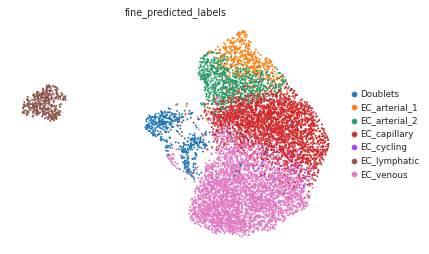

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

In [16]:
adata.obs.donor_disease.unique()

['PIBD', 'cancer', 'UC', 'CD']
Categories (4, object): ['CD', 'PIBD', 'UC', 'cancer']

In [17]:
#fix metadata
adata.obs['disease'] = adata.obs['donor_category'].astype(str) + '_' + adata.obs['donor_disease'].astype(str)

In [18]:
list(adata.obs.disease.unique())

['disease_PIBD', 'disease_cancer', 'disease_UC', 'disease_CD']

In [19]:
adata.obs.disease.value_counts()

disease_cancer    3937
disease_UC        2347
disease_PIBD      1024
disease_CD         813
Name: disease, dtype: int64

In [20]:
adata.obs.donor_disease.unique()

['PIBD', 'cancer', 'UC', 'CD']
Categories (4, object): ['CD', 'PIBD', 'UC', 'cancer']

In [21]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{
'disease_cancer':'cancer',
    'disease_PIBD':'pediatric_IBD',
    'disease_UC':'ulcertaive_colitis',
    'disease_CD':'crohns_disease'
    }.get(x,x)).astype("category"))

In [22]:
cancer = adata[adata.obs['disease'].isin(['cancer'])].copy()

In [23]:
cancer.obs.disease.value_counts()

cancer    3937
Name: disease, dtype: int64

In [24]:
cancer.obs['disease'] = cancer.obs['disease'].astype(str) + '_' + cancer.obs['organ_unified'].astype(str)

In [25]:
cancer.obs.disease.value_counts()

cancer_stomach            2353
cancer_sigmoid colon       428
cancer_colon               405
cancer_rectum              337
cancer_caecum              245
cancer_ascending colon     169
Name: disease, dtype: int64

In [26]:
cancer.obs['disease'] = (cancer.obs['disease'].map(lambda x:{'cancer_caecum':'cancer_colorectal',
 'cancer_rectum':'cancer_colorectal',
 'cancer_sigmoid colon':'cancer_colorectal',
 'cancer_colon':'cancer_colorectal',
 'cancer_ascending colon':'cancer_colorectal',
 'cancer_stomach':'cancer_gastric'}.get(x,x)).astype("category"))

In [27]:
cancer.obs.disease.value_counts()

cancer_gastric       2353
cancer_colorectal    1584
Name: disease, dtype: int64

In [28]:
ON = {O:N for O,N in zip(cancer.obs_names,cancer.obs["disease"])}
adata.obs["disease"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["disease"])]
adata.obs.disease.value_counts()

cancer_gastric        2353
ulcertaive_colitis    2347
cancer_colorectal     1584
pediatric_IBD         1024
crohns_disease         813
Name: disease, dtype: int64

In [29]:
list(adata.obs.disease.unique())

['pediatric_IBD',
 'cancer_colorectal',
 'ulcertaive_colitis',
 'crohns_disease',
 'cancer_gastric']

In [30]:
adata.obs['disease'] = adata.obs['disease'].astype('category')

In [31]:
adata.obs['disease'] = (adata.obs['disease'].map(lambda x:{'ulcertaive_colitis':'ulcerative_colitis'}.get(x,x)).astype("category"))

In [32]:
adata.obs['disease'].cat.reorder_categories([
 'crohns_disease',
 'ulcerative_colitis',
 'pediatric_IBD',
 'cancer_colorectal',
 'cancer_gastric'], inplace=True)

<ipython-input-32-b0e974b68020>:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs['disease'].cat.reorder_categories([


/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


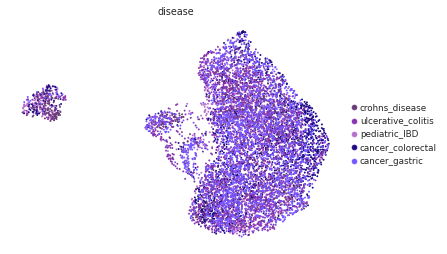

In [33]:
#plot umaps
sc.pl.umap(adata,color = 'disease',palette=[#'#ADD3DD',#control
                                    #'#ffb7b7',#'inutero',
                                     #'#f48154',#'preterm',
                                    '#693C78',#crohn's disease
                                            '#8934B1',#UC
                                            '#B670CD',#PIBD
                                            '#1C0B86',#colorectal cancer
                                            '#7657ff',#gastric cancer
                                           ])

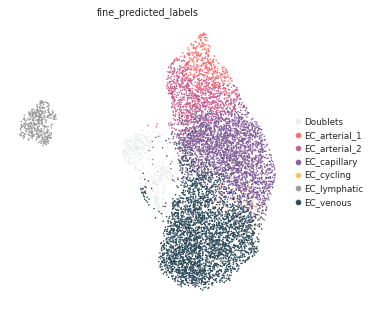

In [36]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858' #venous
                                                         ]
           ,size=10)

In [37]:
adata.X.max()

4818.0

In [38]:
adata.layers['counts'] = adata.X

In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [40]:
marker_genes_dict = {'General EC markers':['PECAM1','CD36'],
                     'General arterial markers':['GJA4','HEY1','CXCL12'],
                     'Arterial 1':['SEMA3G','IGFBP3','FBLN2','FBLN5','ELN'],
                     'Arterial 2':['BTNL9','ALPL'],
                     'Capillary':['RGCC','COL4A1','COL4A2','IL32','MCAM','MYO1B'],
                     'Cycling':['MKI67','TOP2A'],
                     'Lymphatic':['CCL21','TFF3','PROX1','NTS'],
                     'Venous':['ACKR1','CCL14','SELE','TNFRSF6B']}

In [41]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


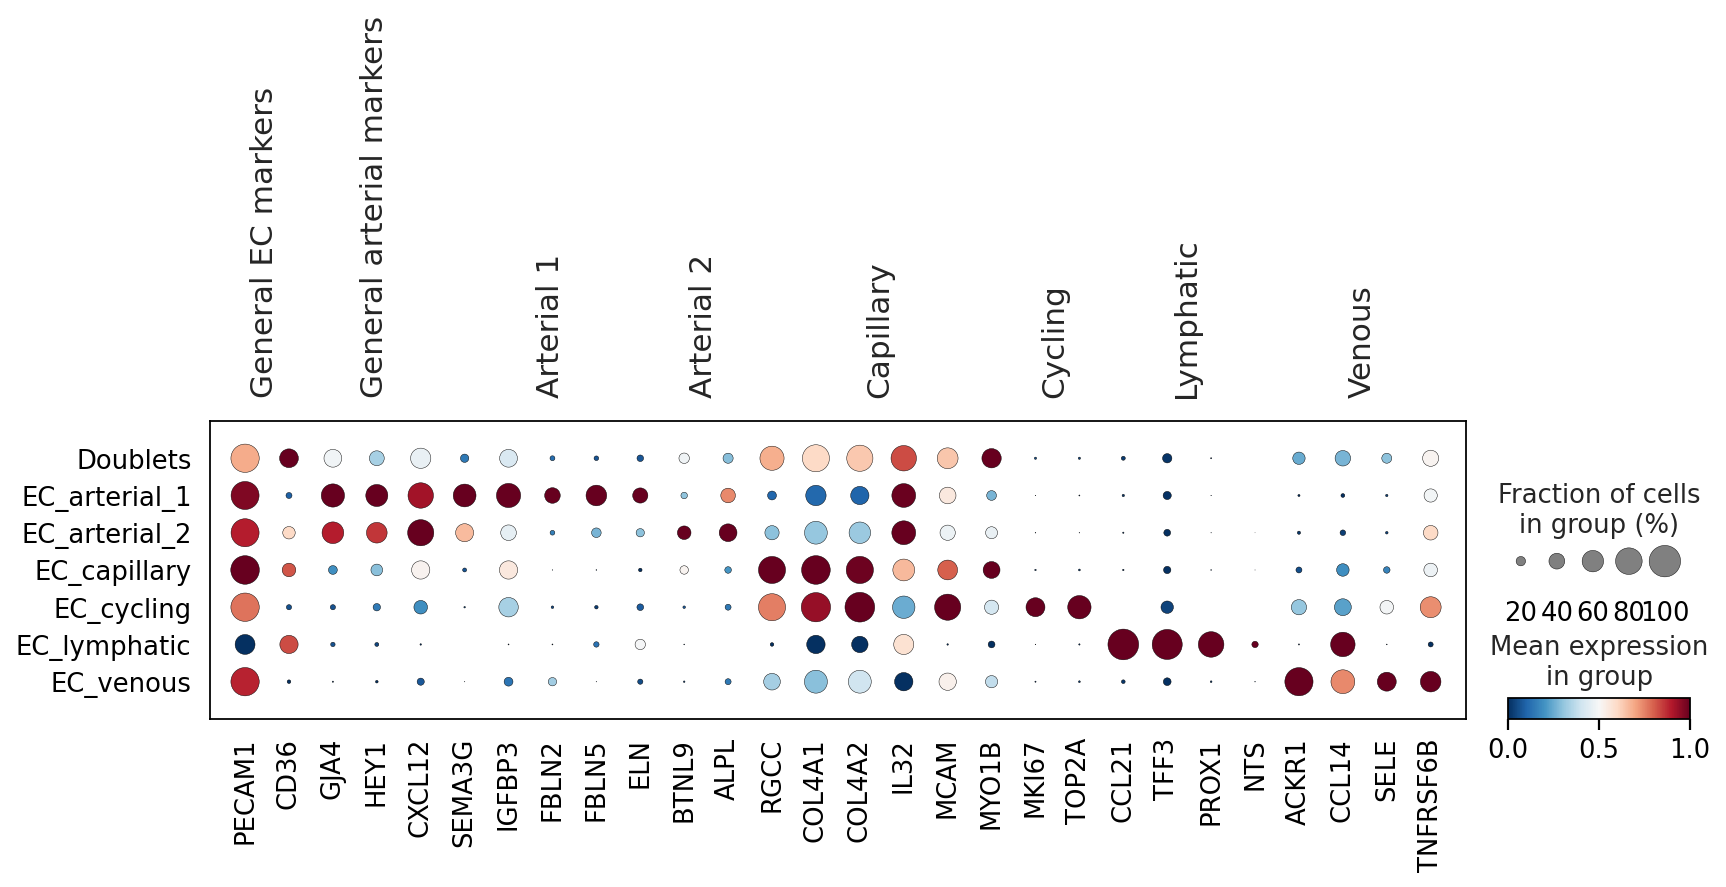

In [42]:
#plot markers
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

### Define uncertain cells

In [43]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [44]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.4599775671958923


(array([3.089e+03, 4.140e+02, 3.110e+02, 5.430e+02, 2.350e+02, 1.900e+02,
        1.960e+02, 3.660e+02, 1.720e+02, 1.630e+02, 1.450e+02, 3.210e+02,
        1.690e+02, 1.380e+02, 2.160e+02, 2.540e+02, 1.630e+02, 1.730e+02,
        3.200e+02, 1.430e+02, 1.070e+02, 7.000e+01, 1.180e+02, 3.900e+01,
        2.400e+01, 2.100e+01, 1.200e+01, 5.000e+00, 1.000e+00, 3.000e+00]),
 array([0.        , 0.02533272, 0.05066545, 0.07599817, 0.10133089,
        0.12666362, 0.15199634, 0.17732906, 0.20266179, 0.22799451,
        0.25332724, 0.27865996, 0.30399268, 0.32932541, 0.35465813,
        0.37999085, 0.40532358, 0.4306563 , 0.45598902, 0.48132175,
        0.50665447, 0.53198719, 0.55731992, 0.58265264, 0.60798537,
        0.63331809, 0.65865081, 0.68398354, 0.70931626, 0.73464898,
        0.75998171]),
 <BarContainer object of 30 artists>)

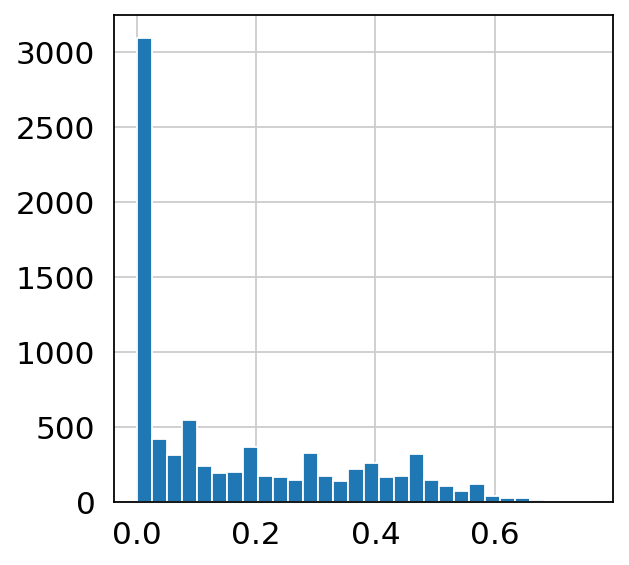

In [45]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)

In [46]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-46-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [47]:
adata.obs['fine_predicted_labels'].unique()

['EC_arterial_2', 'EC_arterial_1', 'EC_venous', 'EC_lymphatic', 'EC_capillary', 'Doublets', 'EC_cycling']
Categories (7, object): ['Doublets', 'EC_arterial_1', 'EC_arterial_2', 'EC_capillary', 'EC_cycling', 'EC_lymphatic', 'EC_venous']

In [48]:
#mark cells are unknown based on cut off of 90th percentile
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > p, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [49]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

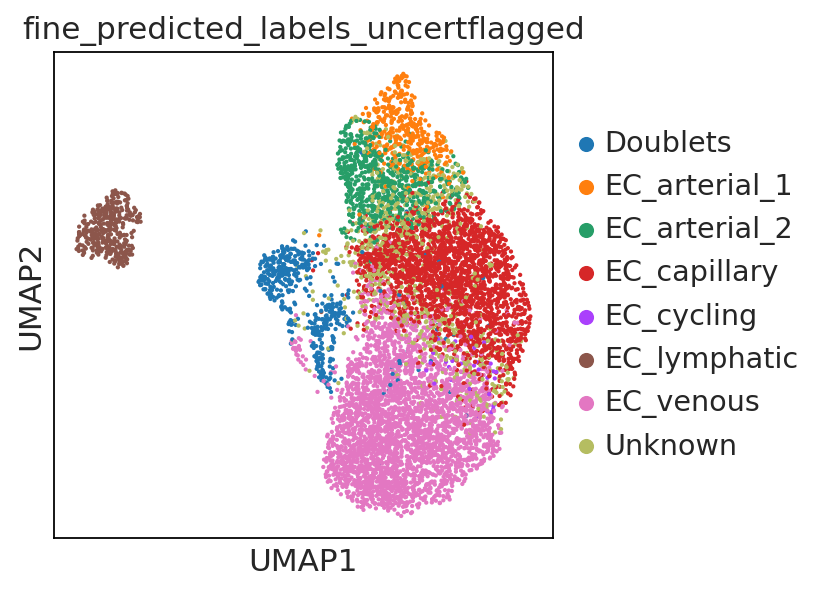

In [50]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

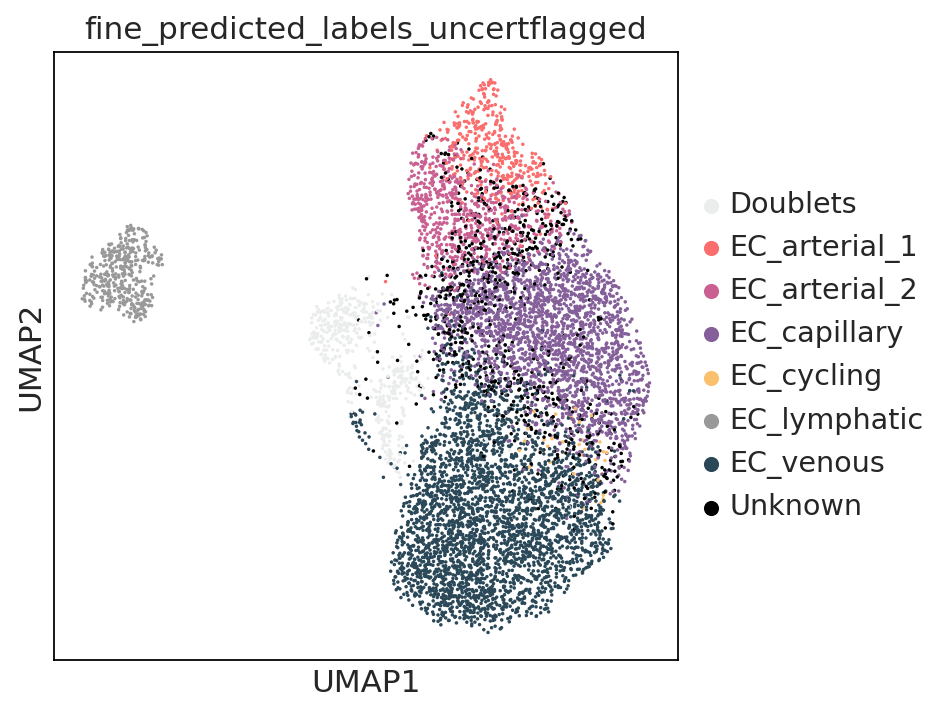

In [54]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858', #venous
'#000000'#unknown
                                                                       ],size=10)

### Finalise annotations
- calculate leiden clusters
- inspect annotations across leiden clusters
- assess marker genes, doublet markers, donor distribution
- relabel based on majority voting of leiden clusters, along with confirmation from marker genes etc.

In [55]:
#reassign labels for unknown cells by leiden clustering and majority voting
sc.tl.leiden(adata,resolution=1,key_added='leiden1')

In [56]:
sc.pl.umap(adata,color='leiden1')

In [57]:
#quick look at leiden resolution 0.5
sc.tl.leiden(adata,resolution=0.5,key_added='leiden0.5')

In [58]:
sc.pl.umap(adata,color='leiden0.5')

In [59]:
pd.crosstab(adata.obs.leiden1,adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  Doublets  EC_arterial_1  EC_arterial_2  \
leiden1                                                                       
0                                           1              0              0   
1                                           7              0             91   
2                                           2              0              0   
3                                           2            354            525   
4                                           0              0              0   
5                                           9              0              0   
6                                           0              0              0   
7                                           9              0              0   
8                                           0              0              0   
9                                           1             42             59   
10                                        259              1              0   
11                                        182              0              6   
12                                          0              0              0   

fine_predicted_labels_uncertflagged  EC_capillary  EC_cycling  EC_lymphatic  \
leiden1                                                                       
0                                               0           0             0   
1                                             804           0             0   
2                                              35          19             0   
3                                              13           0             0   
4                                             697           0             0   
5                                             429          13             0   
6                                              89           4             0   
7                                               2           0             0   
8                                               0           0           392   
9                                             165           0             0   
10                                              3           0             0   
11                                              8           0             0   
12                                              1           0             0   

fine_predicted_labels_uncertflagged  EC_venous  Unknown  
leiden1                                                  
0                                         1170        0  
1                                           46      207  
2                                          958       49  
3                                            1      161  
4                                           19       18  
5                                           78       98  
6                                          315       88  
7                                          425        7  
8                                            0        1  
9                                            0       98  
10                                          25       20  
11                                           9       22  
12                                          73        9

In [60]:
pd.crosstab(adata.obs['leiden0.5'],adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  Doublets  EC_arterial_1  EC_arterial_2  \
leiden0.5                                                                     
0                                           9              0            116   
1                                          10              0              0   
2                                          11              0              0   
3                                           4            396            565   
4                                           0              0              0   
5                                         259              1              0   
6                                         179              0              0   

fine_predicted_labels_uncertflagged  EC_capillary  EC_cycling  EC_lymphatic  \
leiden0.5                                                                     
0                                            1528           1             0   
1                                               6           0             0   
2                                             665          35             0   
3                                              40           0             0   
4                                               0           0           392   
5                                               3           0             0   
6                                               4           0             0   

fine_predicted_labels_uncertflagged  EC_venous  Unknown  
leiden0.5                                                
0                                          194      346  
1                                         1925        9  
2                                          964      169  
3                                            2      224  
4                                            0        1  
5                                           25       19  
6                                            9       10

In [61]:
#Use Leiden resolution 1
unknown = adata.obs[['leiden1','fine_predicted_labels_uncertflagged']]

In [62]:
unknown = unknown[unknown['fine_predicted_labels_uncertflagged'].isin(['Unknown'])]

In [63]:
unknown

leiden1 fine_predicted_labels_uncertflagged
index                                                                       
ACTTGTTGTGAGGGTT-4918STDY7273964       1                             Unknown
ATAAGAGTCTTGCATT-4918STDY7273964       3                             Unknown
CAAGATCCAAGCTGGA-4918STDY7273964       3                             Unknown
GTAGTCACATAGACTC-4918STDY7273964       1                             Unknown
TGAGAGGTCCAAGTAC-4918STDY7273964       3                             Unknown
...                                  ...                                 ...
GTAGGCCTCCAAACTG-GSM4546346            1                             Unknown
GTGCAGCGTACTTAGC-GSM4546346            1                             Unknown
TACACGAGTAAGAGAG-GSM4546346            3                             Unknown
TAGGCATTCAATCACG-GSM4546346            1                             Unknown
TGCCCATCACAAGACG-GSM4546346            1                             Unknown

[778 rows x 2 columns]

In [64]:
sc.pl.umap(adata,color='leiden1')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [65]:
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='leiden1',color_map='RdBu_r', standard_scale='var')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


In [66]:
pd.crosstab(adata.obs.leiden1,adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  Doublets  EC_arterial_1  EC_arterial_2  \
leiden1                                                                       
0                                           1              0              0   
1                                           7              0             91   
2                                           2              0              0   
3                                           2            354            525   
4                                           0              0              0   
5                                           9              0              0   
6                                           0              0              0   
7                                           9              0              0   
8                                           0              0              0   
9                                           1             42             59   
10                                        259              1              0   
11                                        182              0              6   
12                                          0              0              0   

fine_predicted_labels_uncertflagged  EC_capillary  EC_cycling  EC_lymphatic  \
leiden1                                                                       
0                                               0           0             0   
1                                             804           0             0   
2                                              35          19             0   
3                                              13           0             0   
4                                             697           0             0   
5                                             429          13             0   
6                                              89           4             0   
7                                               2           0             0   
8                                               0           0           392   
9                                             165           0             0   
10                                              3           0             0   
11                                              8           0             0   
12                                              1           0             0   

fine_predicted_labels_uncertflagged  EC_venous  Unknown  
leiden1                                                  
0                                         1170        0  
1                                           46      207  
2                                          958       49  
3                                            1      161  
4                                           19       18  
5                                           78       98  
6                                          315       88  
7                                          425        7  
8                                            0        1  
9                                            0       98  
10                                          25       20  
11                                           9       22  
12                                          73        9

In [67]:
unknown_adata = adata[adata.obs['fine_predicted_labels_uncertflagged'].isin(['Unknown'])].copy()

In [68]:
sc.pl.dotplot(unknown_adata,var_names=marker_genes_dict,groupby='leiden1',color_map='RdBu_r', standard_scale='var')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


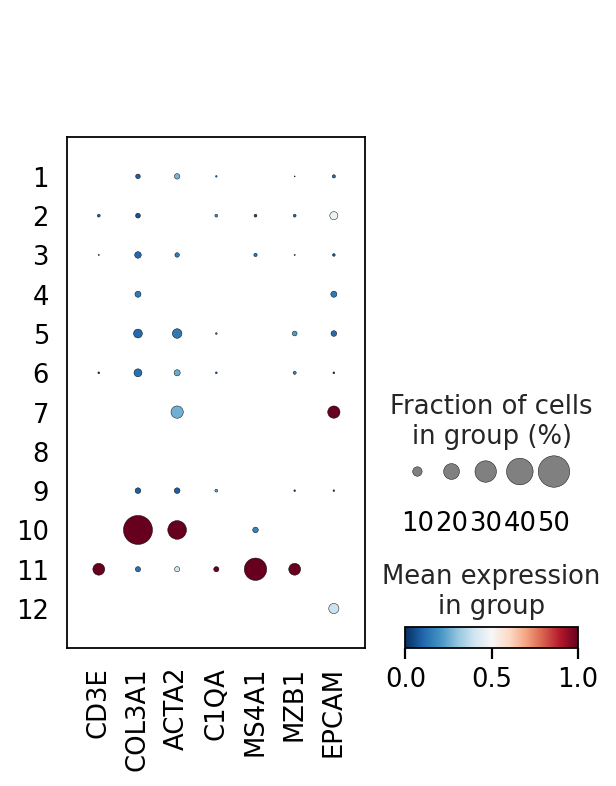

In [69]:
#plot some doublet markers
sc.pl.dotplot(unknown_adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1','EPCAM'],groupby='leiden1',color_map='RdBu_r', standard_scale='var')

In [70]:
#plot some doublet markers
sc.pl.dotplot(adata,var_names=['CD3E','COL3A1','ACTA2','C1QA','MS4A1','MZB1','EPCAM'],groupby='leiden1',color_map='RdBu_r', standard_scale='var')

In [71]:
sc.pl.umap(adata,color='leiden1')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


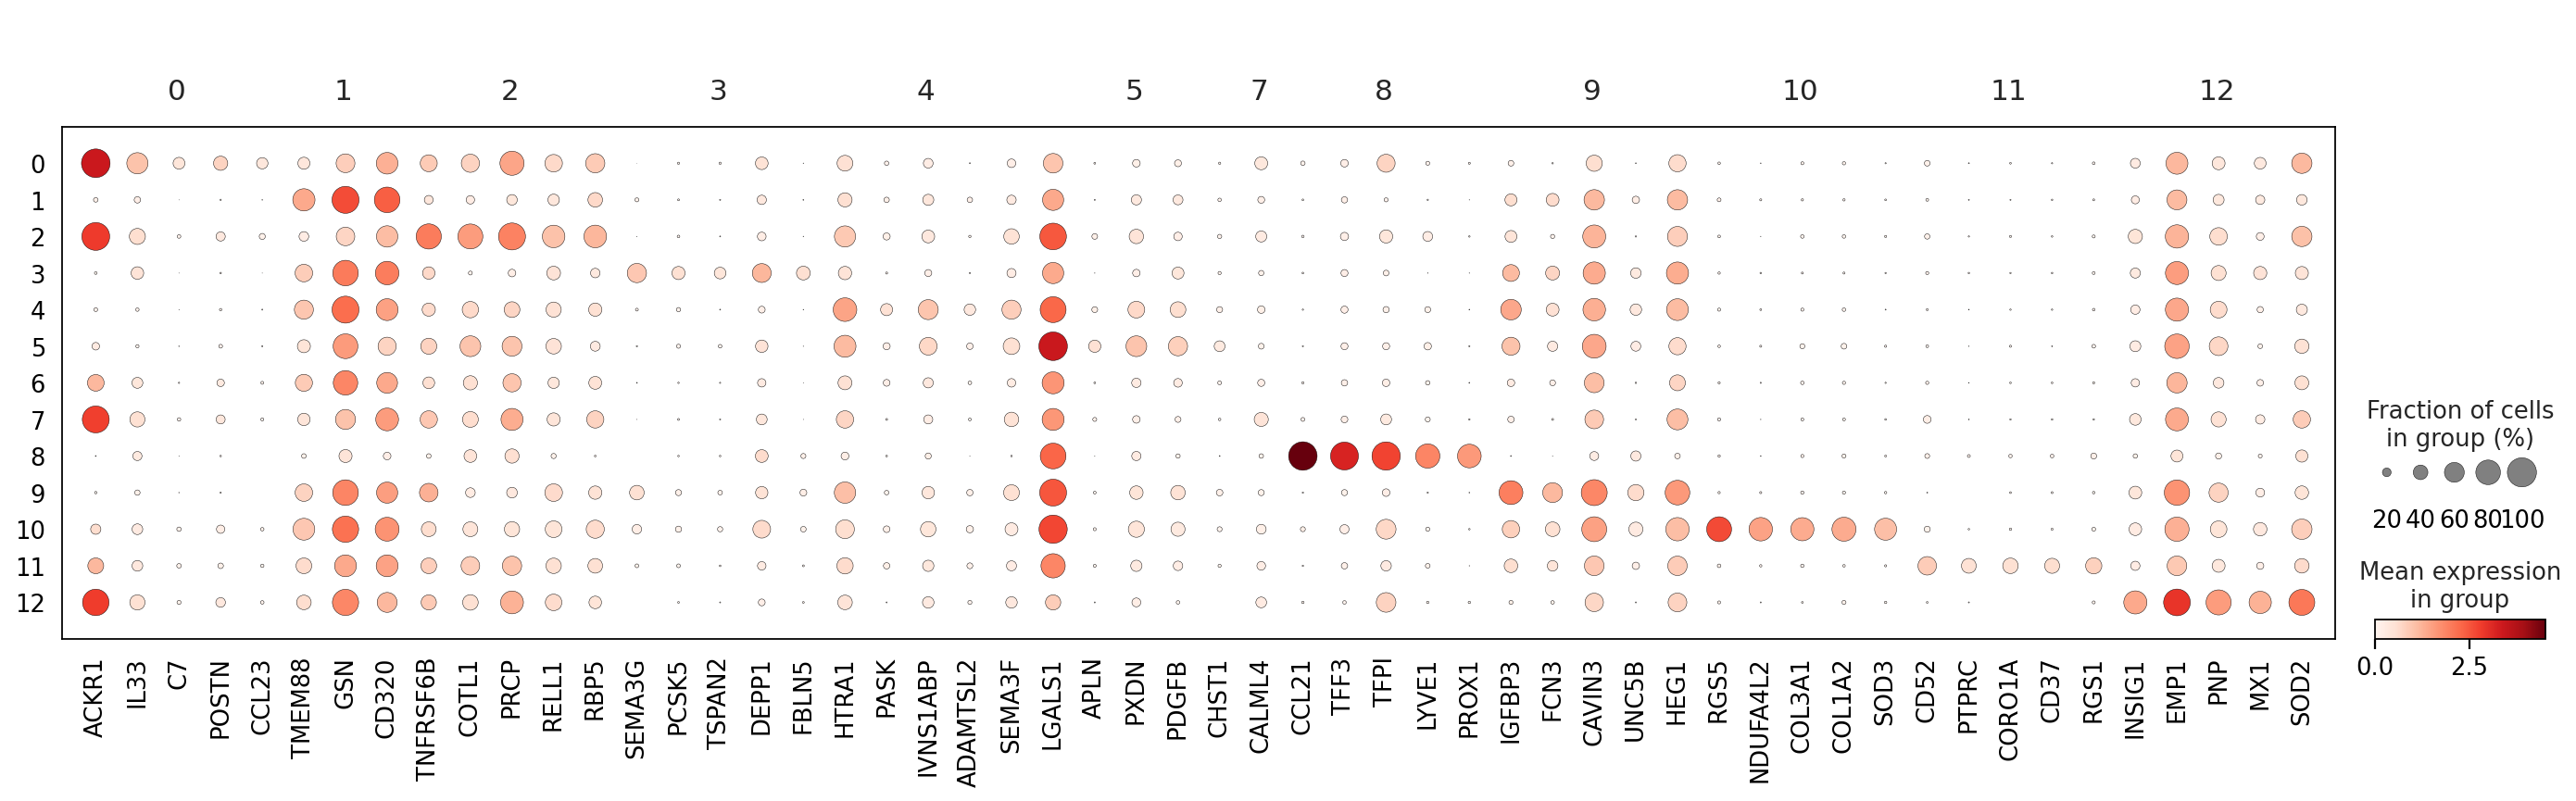

In [72]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="leiden1")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='leiden1', mks=mks)

In [73]:
sc.pl.umap(adata,color='donorID_unified')

In [74]:
sc.pl.umap(adata,color='study')

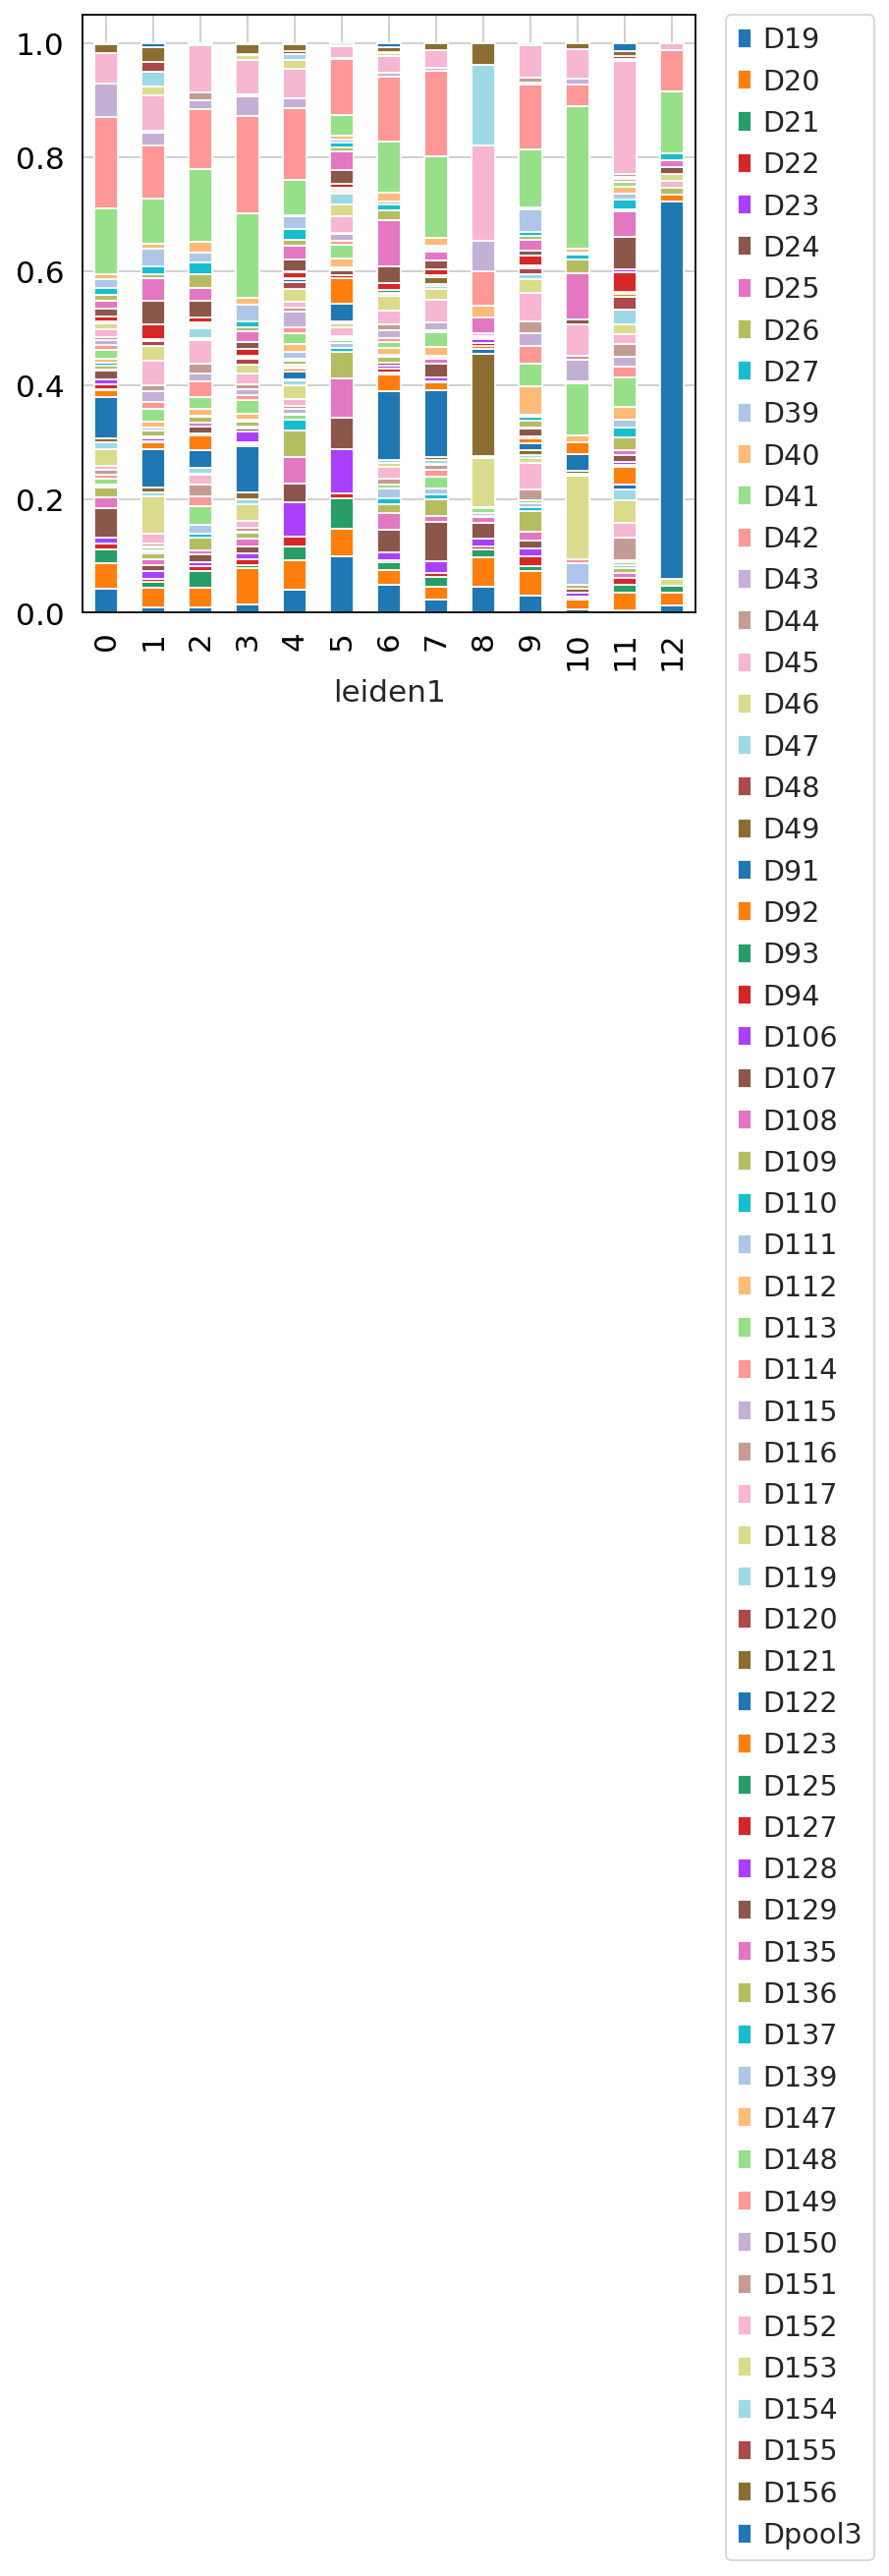

In [75]:
tmp = pd.crosstab(adata.obs['leiden1'], adata.obs['donorID_unified'],normalize='index'
                                                                         )
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

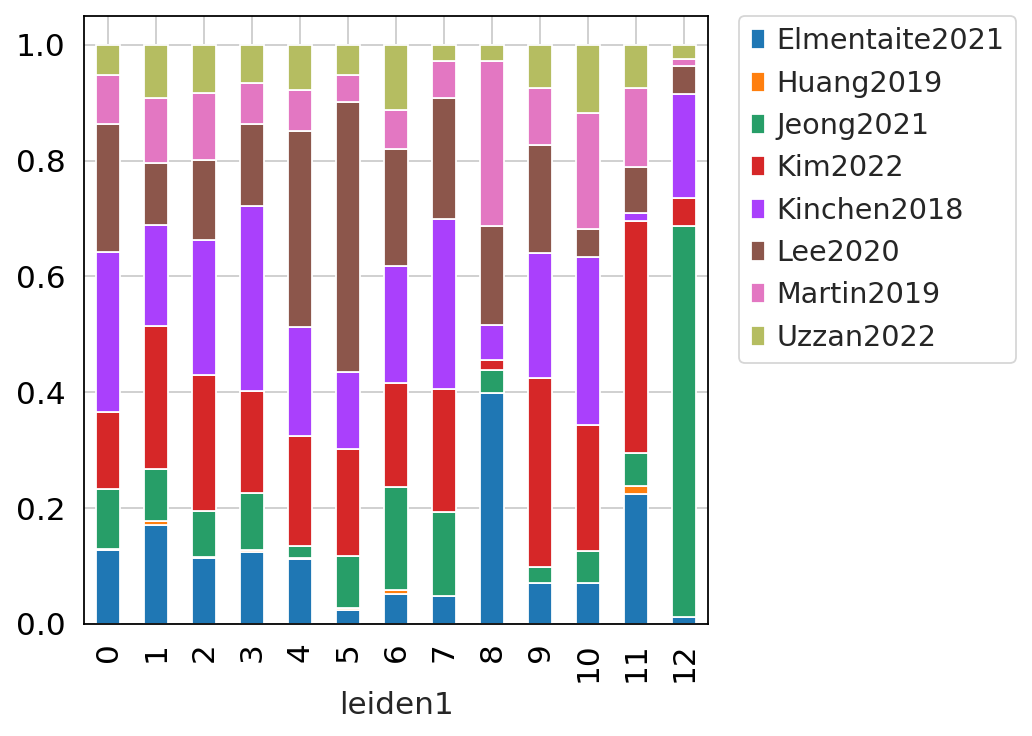

In [76]:
tmp = pd.crosstab(adata.obs['leiden1'], adata.obs['study'],normalize='index'
                                                                         )
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

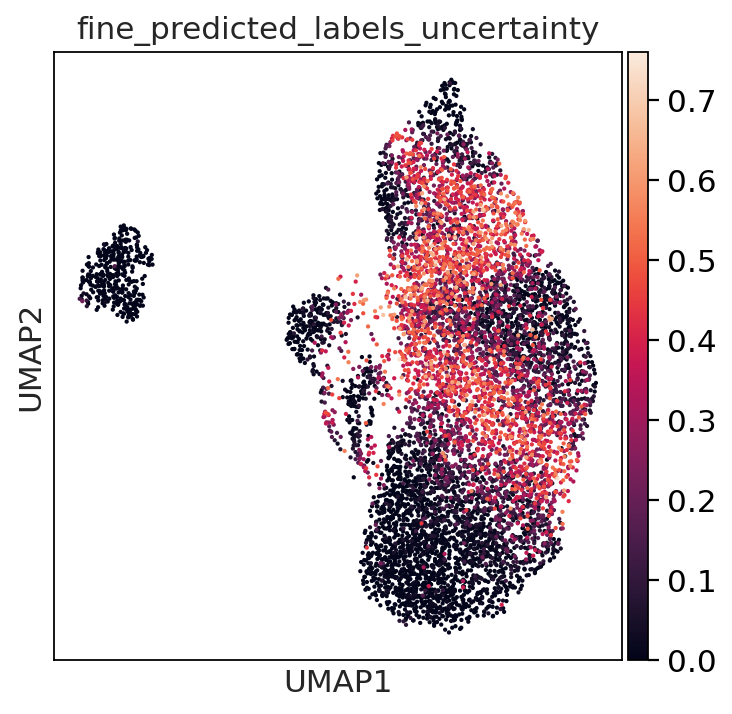

In [77]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty')

In [78]:
pd.crosstab(adata.obs.leiden1,adata.obs.disease)

disease  crohns_disease  ulcerative_colitis  pediatric_IBD  cancer_colorectal  \
leiden1                                                                         
0                   100                 384            151                258   
1                   130                 306            206                125   
2                   122                 336            123                148   
3                    76                 407            134                148   
4                    52                 195             83                249   
5                    29                 117             17                292   
6                    33                 157             29                100   
7                    29                 142             21                 92   
8                   112                  35            157                 67   
9                    36                 106             26                 68   
10                   62                 125             22                 15   
11                   31                  20             54                 18   
12                    1                  17              1                  4   

disease  cancer_gastric  
leiden1                  
0                   278  
1                   388  
2                   334  
3                   291  
4                   155  
5                   172  
6                   177  
7                   159  
8                    22  
9                   129  
10                   84  
11                  104  
12                   60

In [82]:
sc.pl.dotplot(adata,var_names=['HEY1','ELN','ALPL','BTNL9'],groupby='leiden1')

In [83]:
sc.pl.umap(adata,color=['HEY1','ELN','ALPL','BTNL9'],cmap='OrRd')

In [81]:
pd.crosstab(adata.obs.leiden1,adata.obs.fine_predicted_labels_uncertflagged)

fine_predicted_labels_uncertflagged  Doublets  EC_arterial_1  EC_arterial_2  \
leiden1                                                                       
0                                           1              0              0   
1                                           7              0             91   
2                                           2              0              0   
3                                           2            354            525   
4                                           0              0              0   
5                                           9              0              0   
6                                           0              0              0   
7                                           9              0              0   
8                                           0              0              0   
9                                           1             42             59   
10                                        259              1              0   
11                                        182              0              6   
12                                          0              0              0   

fine_predicted_labels_uncertflagged  EC_capillary  EC_cycling  EC_lymphatic  \
leiden1                                                                       
0                                               0           0             0   
1                                             804           0             0   
2                                              35          19             0   
3                                              13           0             0   
4                                             697           0             0   
5                                             429          13             0   
6                                              89           4             0   
7                                               2           0             0   
8                                               0           0           392   
9                                             165           0             0   
10                                              3           0             0   
11                                              8           0             0   
12                                              1           0             0   

fine_predicted_labels_uncertflagged  EC_venous  Unknown  
leiden1                                                  
0                                         1170        0  
1                                           46      207  
2                                          958       49  
3                                            1      161  
4                                           19       18  
5                                           78       98  
6                                          315       88  
7                                          425        7  
8                                            0        1  
9                                            0       98  
10                                          25       20  
11                                           9       22  
12                                          73        9

In [84]:
unknown['fine_predicted_labels_resolved'] = (unknown['leiden1']
        .map(lambda x:{
                       '1':'EC_capillary',
                       '2':'EC_venous',
                       '3':'EC_arterial_2', 
                       '4':'EC_capillary',
                       '5':'EC_capillary', 
                       '6':'EC_venous',
                       '7':'EC_venous',
                       '8':'EC_lymphatic', 
                       '9':'EC_capillary',
                       '10':'Doublets',
                       '11':'Doublets', 
                       '12':'EC_venous'
                         }.get(x,x)).astype('category'))

In [85]:
unknown

leiden1 fine_predicted_labels_uncertflagged  \
index                                                                          
ACTTGTTGTGAGGGTT-4918STDY7273964       1                             Unknown   
ATAAGAGTCTTGCATT-4918STDY7273964       3                             Unknown   
CAAGATCCAAGCTGGA-4918STDY7273964       3                             Unknown   
GTAGTCACATAGACTC-4918STDY7273964       1                             Unknown   
TGAGAGGTCCAAGTAC-4918STDY7273964       3                             Unknown   
...                                  ...                                 ...   
GTAGGCCTCCAAACTG-GSM4546346            1                             Unknown   
GTGCAGCGTACTTAGC-GSM4546346            1                             Unknown   
TACACGAGTAAGAGAG-GSM4546346            3                             Unknown   
TAGGCATTCAATCACG-GSM4546346            1                             Unknown   
TGCCCATCACAAGACG-GSM4546346            1                             Unknown   

                                 fine_predicted_labels_resolved  
index                                                            
ACTTGTTGTGAGGGTT-4918STDY7273964                   EC_capillary  
ATAAGAGTCTTGCATT-4918STDY7273964                  EC_arterial_2  
CAAGATCCAAGCTGGA-4918STDY7273964                  EC_arterial_2  
GTAGTCACATAGACTC-4918STDY7273964                   EC_capillary  
TGAGAGGTCCAAGTAC-4918STDY7273964                  EC_arterial_2  
...                                                         ...  
GTAGGCCTCCAAACTG-GSM4546346                        EC_capillary  
GTGCAGCGTACTTAGC-GSM4546346                        EC_capillary  
TACACGAGTAAGAGAG-GSM4546346                       EC_arterial_2  
TAGGCATTCAATCACG-GSM4546346                        EC_capillary  
TGCCCATCACAAGACG-GSM4546346                        EC_capillary  

[778 rows x 3 columns]

In [86]:
adata

AnnData object with n_obs × n_vars = 8121 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spli

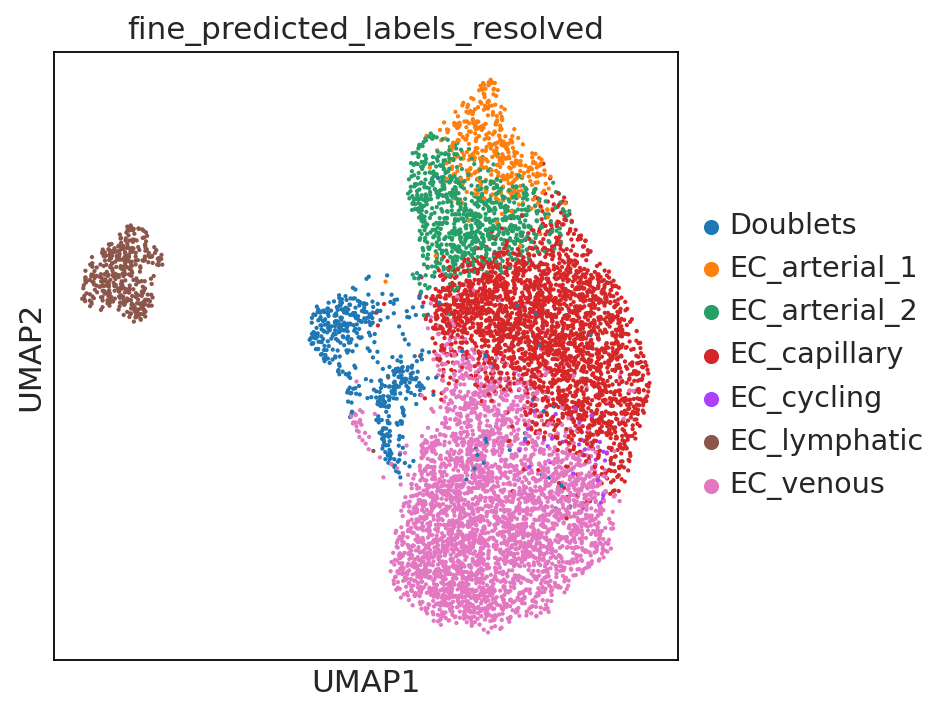

In [87]:
ON = {O:N for O,N in zip(unknown.index,unknown["fine_predicted_labels_resolved"])}
adata.obs["fine_predicted_labels_resolved"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_resolved')

In [88]:
no_doublets = adata[~adata.obs.fine_predicted_labels_resolved.isin(['Doublets'])].copy()

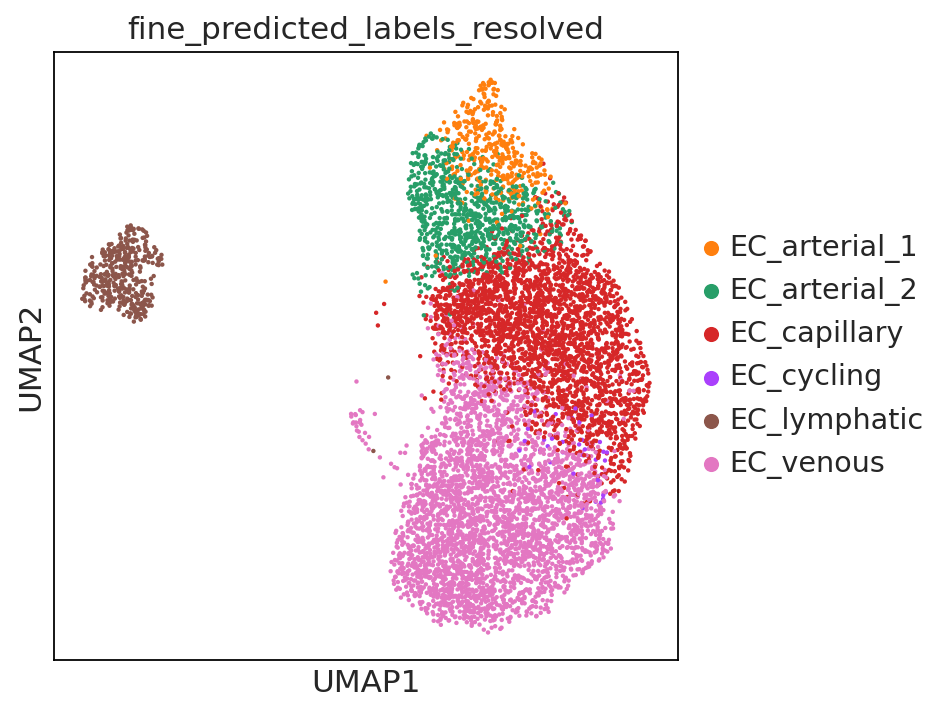

In [89]:
sc.pl.umap(no_doublets,color='fine_predicted_labels_resolved')

In [91]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#ebeded',#doublets
                                                          '#fa6e6e',#arterial 1
                                                          '#ca6092',#arterial 2
                                                          '#855f9a',#capillary
                                                          '#fac06e',#cycling
                                                          '#999999',#lymphatic
                                                          '#2a4858', #venous

    
                                              ],size=10)

In [92]:
annot = adata.obs[['fine_predicted_labels_uncertflagged','fine_predicted_labels_resolved']]

In [93]:
annot

fine_predicted_labels_uncertflagged  \
index                                                                  
AAAGCAAAGAGCTGGT-4918STDY7273964                       EC_arterial_2   
AACCATGTCCAGTAGT-4918STDY7273964                       EC_arterial_1   
AACTGGTGTAGCTCCG-4918STDY7273964                       EC_arterial_2   
AAGCCGCTCGTACGGC-4918STDY7273964                           EC_venous   
AAGGCAGGTAGCACGA-4918STDY7273964                           EC_venous   
...                                                              ...   
TTGACTTTCCTACAGA-GSM4546346                                EC_venous   
TTGCGTCTCCCAAGTA-GSM4546346                            EC_arterial_2   
TTTACTGCAAACCCAT-GSM4546346                                EC_venous   
TTTGGTTAGATCGATA-GSM4546346                                EC_venous   
TTTGGTTAGATTACCC-GSM4546346                                EC_venous   

                                 fine_predicted_labels_resolved  
index                                                            
AAAGCAAAGAGCTGGT-4918STDY7273964                  EC_arterial_2  
AACCATGTCCAGTAGT-4918STDY7273964                  EC_arterial_1  
AACTGGTGTAGCTCCG-4918STDY7273964                  EC_arterial_2  
AAGCCGCTCGTACGGC-4918STDY7273964                      EC_venous  
AAGGCAGGTAGCACGA-4918STDY7273964                      EC_venous  
...                                                         ...  
TTGACTTTCCTACAGA-GSM4546346                           EC_venous  
TTGCGTCTCCCAAGTA-GSM4546346                       EC_arterial_2  
TTTACTGCAAACCCAT-GSM4546346                           EC_venous  
TTTGGTTAGATCGATA-GSM4546346                           EC_venous  
TTTGGTTAGATTACCC-GSM4546346                           EC_venous  

[8121 rows x 2 columns]

In [95]:
#export final annotations
annot.to_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Endo_disease_annot.csv')